This code is used for 2 main purposes: 
1- Read the original signals (ECG, PPG, ABP), and extract features and labels from them. Then saving a dataset of those features & labels to be used for the train & test processes. 
If you already have the extracted features, jump to "Start Here When You Have Processed Data!"

2- Apply different ML techniques on the generated data (LR, SVM, DT, RF, AB, PR), get predictions, save Models, C-Codes, and Results. 

# Reduced Dataset from UCI 

## Loading data and calculating indices 

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # for the progress bar :) 

In [3]:
# for single csv file of 1,000 instants, use this directory & change file name as needed
#Data_Dir = "C:/1_Work/FANOS_lab/Reduced_Processed_Dataset_UCI_Kauchee/Generated_CSVs_from_Reduced_Dataset/12_Files_1000_instant_each/"
#File_name = "1.csv" # files 1 - 12, each with 1,000 instants

# To load all data from a single file: 
Data_Dir = "C:/1_Work/FANOS_lab/Reduced_Processed_Dataset_UCI_Kauchee/Generated_CSVs_from_Reduced_Dataset/Single_File/"
File_name = "All_Signals.csv" # All instants, 12,000, in a single csv file

# Now read data header-less then give the col names
Signals = pd.read_csv(Data_Dir + File_name, header=None) #.reset_index()
Signals.columns = ['PPG','ABP','ECG'] # adding columns' names

# Reading the instants' lengthes to be used for calculating indices
Data_Indices = pd.read_csv(Data_Dir+"Instants_Length.csv", header=None)
Data_Indices.columns = ['Num_Samples']

# Calculating Instant Indices, Start & End
End_indices = np.cumsum(Data_Indices["Num_Samples"])
Start_indices = np.append(0, End_indices) 

# Sampling frequency
Fs=125

## Converting signals into PTT, PTTm, PTTh, HR, SBP, DBP, MAP values

In [9]:
# Looping over the instants, processing them one by one, storing processed data (PTT, SBP, DBP) in another dataframe
All_Instants_Data = pd.DataFrame() 

# Which instants would you like to explore?
iStart, iEnd = 1, 12000 # 1:12,000 
Instants_ID = np.arange(iStart - 1, iEnd)
Subset_Size = 8*125 # how many seconds to take at a time

for ID in tqdm(Instants_ID):  
    Instant_DF = Process_Instant(Signals.iloc[Start_indices[ID]:End_indices[ID]+1], Subset_Size)  # Processing data for 1 instant
    All_Instants_Data = All_Instants_Data.append(Instant_DF, ignore_index=True) # Appending to the whole processed dataset

  2%|███                                                                                                                                                                                                | 189/12000 [00:19<21:30,  9.15it/s]C:\Users\ahmedk1\.conda\envs\fromBase\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ahmedk1\.conda\envs\fromBase\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [15:13<00:00, 13.14it/s]


In [24]:
All_Instants_Data.describe()

,PTTh,PTTm,PTT,HR,SBP,DBP,MAP
count,224017.000000,224017.000000,224017.000000,224017.000000,224017.000000,224017.000000,224017.000000
mean,1.502436,1.125356,0.575596,92.394599,133.576023,71.387614,93.667467
std,0.471776,0.467996,0.328781,15.733808,20.316135,9.771469,11.612897
min,0.132734,0.030500,0.008000,54.415423,80.019000,60.000000,66.646760
25%,1.391544,0.924800,0.432667,80.456582,118.808333,64.047526,85.024067
50%,1.673225,1.120000,0.612571,91.519219,132.973333,68.917933,91.924155
75%,1.827060,1.282667,0.664615,102.120974,148.020000,76.167333,100.996230
max,2.608299,4.086000,2.256800,155.795596,180.000000,129.955385,148.771474


In [40]:
All_Instants_Data.loc[:,['HR','SBP', 'DBP','MAP']].describe().to_csv("data_description_after_removing_outliers.csv")#Saving Stats

In [14]:
All_Instants_Data.to_csv('Extracted_Instants_Parameters_8secWindow_PTTm_PTTh_MAP_210621.csv') # Saving Dataset

## Helper Functions

### PPG, ABP, ECG signals to PTT, PTTm, PTTh, SBP, DBP, MAP, HR values

In [8]:
def Process_Instant(Signals, Subset_Size = 125*3): # defulat Subset_Size to cover 3 seconds of data samples
    
    import numpy as np
    from scipy.signal import find_peaks
    import pandas as pd
    
    N_tot = len(Signals.index) # Total number of samples
    N_ps = Subset_Size # Num of points per subset
    N_ss = N_tot//N_ps # Number of subsets (each with N_ps points), discarding the last points < N_ps
    All_data=pd.DataFrame() # an empty DF to store the parameters we got from the processed data 
    fs=125 # used to convert PPTp from Number_of_samples to time (same as in main. If changed, pass it to this fn)
    
    for i in range(N_ss):  # USE find_peaks_cwt instead??
           
        # I found, imperically, that find_peaks works better for PPG compared with ECG & ABP
        # So, I am detecting PPG peaks fisrt, then using 0.8*its average distance to be the min spacing for ECG & ABP peaks!
        # Hopefully this may return more accurate PTT calculations
        
        
        # PPG peaks' locations
        PPG_peaks, _ = find_peaks(Signals['PPG'][i*N_ps:(i+1)*N_ps], distance=40)
        if len(PPG_peaks)<2: 
            print('PPG')
            continue
        
        New_dist = 0.8*np.mean(np.diff(PPG_peaks))
        
        # PPG min' locations
        PPG_min, _ = find_peaks(-1*Signals['PPG'][i*N_ps:(i+1)*N_ps], distance=New_dist)
        if len(PPG_min)<2: 
            print('PPG')
            continue
        
        # ECG peaks' locations & MAP 
        ECG_peaks, _ = find_peaks(Signals['ECG'][i*N_ps:(i+1)*N_ps], distance=New_dist) 
        MAP = np.mean(Signals['ABP'].iloc[i*N_ps + np.arange(ECG_peaks[0], ECG_peaks[-1]+1)].values) #### VALUES not indicies
        if len(ECG_peaks)<2: 
            print('ECG')
            continue
        
        
        if PPG_peaks[-1]<ECG_peaks[0]: 
            print('ECG lagging too much')
            continue
        
        # PPT Calculations:
        # The 1st PPG peak has to lag the 1st ECG peak, if not then drop it and consider the next one.
        Lp, Le, Lm = len(PPG_peaks), len(ECG_peaks), len(PPG_min)
        min_pe = min(Lp, Le, Lm)
        Lpe = min(Lp,Le)
        Lme = min(Lm,Le)
        Lmp = min(Lp,Lm)
        
        if (PPG_peaks[0]>ECG_peaks[0]) and (PPG_min[0]>PPG_peaks[0]): # may add more conditions here for ACCEPTABLE PTT values
            PTT_vec = PPG_peaks[:Lpe] - ECG_peaks[:Lpe]
            PTT_min_vec = PPG_min[:Lme] - ECG_peaks[:Lme]
            PTT_h_vec = Signals['PPG'].iloc[i*N_ps + PPG_peaks[:Lmp]].values - Signals['PPG'].iloc[i*N_ps + PPG_min[:Lmp]].values #### VALUES not indicies
            
        else: # start from the 2nd PPG peak all the way to one before the last ECG peak
            s = 1
            while (PPG_peaks[s]<ECG_peaks[0]) and (s<=Lp-1):
                s+=1
            ind_max_ECG = min(Lp-s,Le) # common last elem index between max & ECG vectors
            PTT_vec = PPG_peaks[s:s+ind_max_ECG] - ECG_peaks[:ind_max_ECG] # PATp
            
            # Now making sure that min's follows max's
            r = 0
            while (PPG_min[r]<PPG_peaks[s]) and (r<=Lm-1):
                r+=1
            ind_m_ECG = min(Lm-r,Le) # common last elem index between min & ECG vectors
            PTT_min_vec = PPG_min[r:r+ind_m_ECG] - ECG_peaks[:ind_m_ECG] # PATf
            ind_h_min = min(Lp-s, Lm-r) # common last elem index between min & max vectors
            PTT_h_vec = Signals['PPG'].iloc[i*N_ps + PPG_peaks[s:s+ind_h_min]].values - Signals['PPG'].iloc[i*N_ps + PPG_min[r:r+ind_h_min]].values # PPGmax - PPGmin (i.e. PPG height)
        
        PTT_vec_p = [x for x in PTT_vec if x>0] # forcing positive values
        PTT_min_vec_p = [x for x in PTT_min_vec if x>0]
        PTT_h_vec_p = [x for x in PTT_h_vec if x>0]
        
        PTT_avg = np.mean(PTT_vec_p)
        PTT_min_avg = np.mean(PTT_min_vec_p)
        PTT_h_avg = np.mean(PTT_h_vec_p)
        
        
        
        # BP Min & Max Peaks' (DBP & SBP) locations
        BPmax_peaks, _ = find_peaks(Signals['ABP'][i*N_ps:(i+1)*N_ps], distance=New_dist) # indices of SBP
        BPmin_peaks, _ = find_peaks(-1*Signals['ABP'][i*N_ps:(i+1)*N_ps], distance=New_dist) # indices of DBP
        
        
            # Calculate HR by averaging distances from ECG, PPG, BPmax, BPmin
        HR_ECG = np.mean(np.diff(ECG_peaks))
        HR_PPG = np.mean(np.diff(PPG_peaks))
        HR_PPG_min = np.mean(np.diff(PPG_min))
        HR_SBP = np.mean(np.diff(BPmax_peaks))
        HR_DBP = np.mean(np.diff(BPmin_peaks))
        HR_avg = 125*60/((HR_ECG + HR_PPG + HR_SBP + HR_DBP + HR_PPG_min)/5) # HR per minute
        ############################ 125*60/(mean(diff))
        
        # Creating DF's of SBP, DBP, and HR along with the time axis to be merged with the Subset DF
        SBP_avg = np.mean(Signals.iloc[i*N_ps + BPmax_peaks].loc[:,['ABP']])
        DBP_avg = np.mean(Signals.iloc[i*N_ps + BPmin_peaks].loc[:,['ABP']]) 
        
        
        # Append log_PPT, log-scale is more convinient for estimating BP (inspired from an approx eqn)
        Subset_DF = pd.DataFrame({'PTT':np.log(PTT_avg/fs), 
                                  'PTTm':np.log(PTT_min_avg/fs), 
                                  'PTTh':PTT_h_avg,
                                  'SBP':SBP_avg,
                                  'DBP':DBP_avg,
                                  'MAP':MAP,
                                  'HR':HR_avg})
         
        
        # Finally, append the DF of the current subset to the whole DF for all patients (may add more numerics, ID, ... later)
        All_data=All_data.append(Subset_DF, ignore_index=True)
    return All_data
    

# Start Here When You Have Processed Data! 

## 3) Preparing Data for Regression [Predictive Models]

### 3.0 Load Data, Remove NaN & Outliers

In [88]:
import pandas as pd
import numpy as np

take_log_PTT = 0 # if not log, then all values are positive & the outliers are as defined
Remove_HR_Outliers = 1 # =1 if required more constraints on HR ( 54.4 < HR < 155.8) 
Remove_PTT_Outliers = 1
Remove_BP_Outliers = 1

Remove_PTTm_Outliers = 0 #(PATf)
Remove_PTTh_Outliers = 0 #(PPG Max-to-Min)


All_Instants_Data2 = pd.read_csv('Extracted_Instants_Parameters_8secWindow_PTTm_PTTh_MAP_210621.csv')
All_Instants_Data2.dropna(inplace=True)
All_Instants_Data = All_Instants_Data2

if take_log_PTT != 1:
    All_Instants_Data['PTT'] = np.exp(All_Instants_Data['PTT']) ################ NOT LOG ANYMORE # By commenting this, it is log
    All_Instants_Data['PTTm'] = np.exp(All_Instants_Data['PTTm'])

# Removing BP Outliers
if Remove_BP_Outliers == 1:
    cond_BP = ((All_Instants_Data['SBP']<180) & (All_Instants_Data['SBP']>80)) & ((All_Instants_Data['DBP']<130) & (All_Instants_Data['DBP']>60))
    All_Instants_Data= All_Instants_Data.loc[cond_BP, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

# Removing HR Outliers
if Remove_HR_Outliers == 1: 
    cond_HR = ((All_Instants_Data['HR']>54.4) & (All_Instants_Data['HR']<155.8))
    All_Instants_Data= All_Instants_Data.loc[cond_HR, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTT Ouliers (outlier if PTT>1.5) # So far, considering PTT<0.5 range gave the best result
if Remove_PTT_Outliers == 1: 
    cond_PTT = (All_Instants_Data['PTT']<0.4) #& (All_Instants_Data['PTT']>0.2)#& (All_Instants_Data['PTT']>.015) #### KEEP <0.4 only ##################
    All_Instants_Data= All_Instants_Data.loc[cond_PTT, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTm (PATf) Outliers
if Remove_PTTm_Outliers == 1: 
    cond_PTTm = ((All_Instants_Data['PTTm']>0.7) & (All_Instants_Data['PTTm']<1.5))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTm, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTh (PPG Max-to-Min) Outliers
if Remove_PTTh_Outliers == 1: 
    cond_PTTh = ((All_Instants_Data['PTTh']>1) & (All_Instants_Data['PTTh']<2))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTh, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

## Regression (Train & Test Results, Accuracies, and Statistics)

C:\Users\ahmedk1\.conda\envs\py371_sklearn0201\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\Users\ahmedk1\.conda\envs\py371_sklearn0201\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

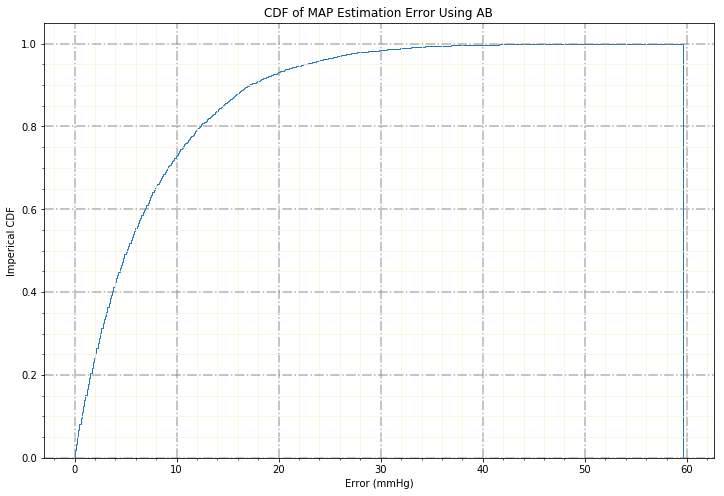

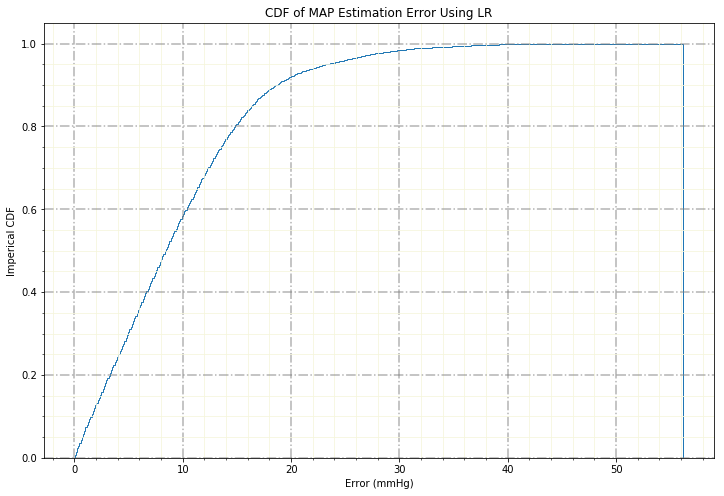

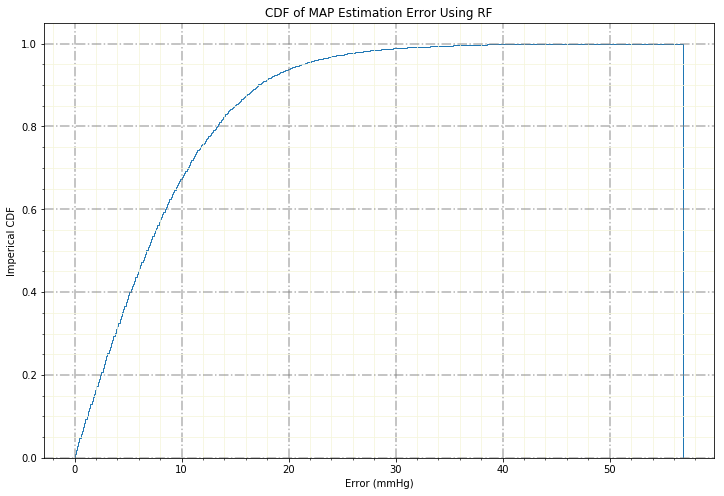

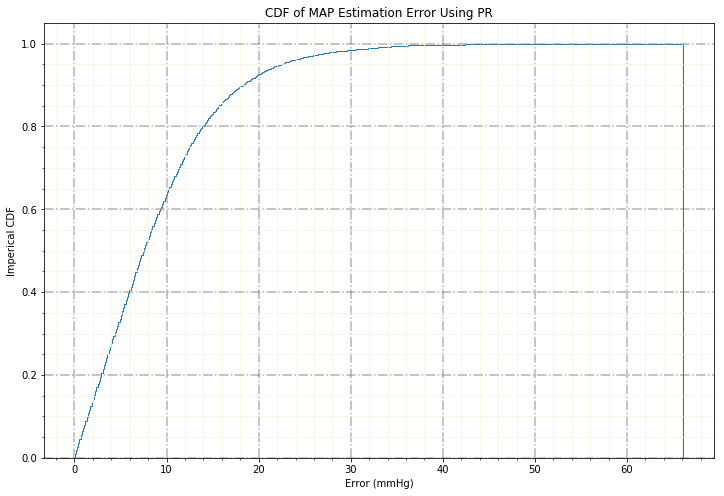

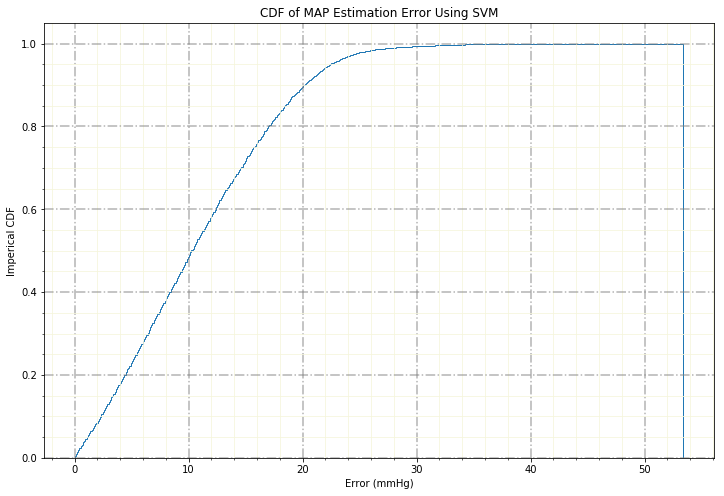

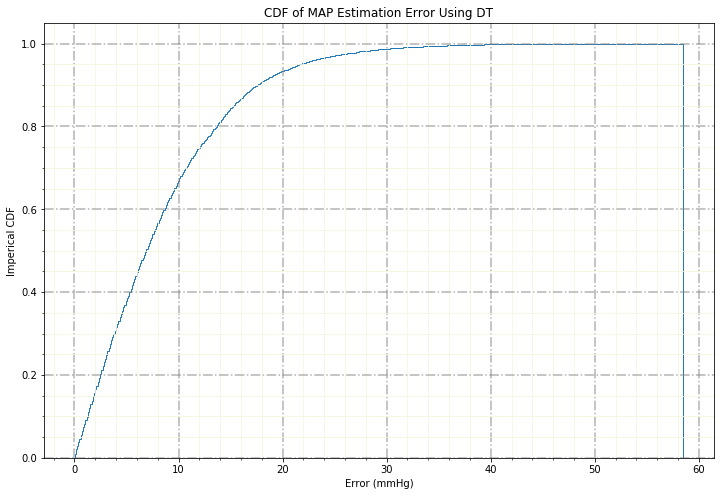

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from FilesfnCopy import RemoveGarbageEncodeObjects, display_scores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from datetime import datetime
import m2cgen as m2c
import joblib # to save: joblib.dump(model, model_file) .. to load: xyz = joblib.load("model_name_as_saved.pkl")


TARGET = 'MAP' # SBP or DBP or MAP
Reg_Model_vec = ['AB', 'LR', 'RF', 'PR', 'SVM', 'DT']


######################################################################
# Data Shuffling and Scaling
do_scaling = 0
temp_data = All_Instants_Data.loc[:, ['PTTh','PTTm','PTT','HR']]
train_copy2_tr, test_copy_tr, train_labels, test_labels = train_test_split(temp_data, All_Instants_Data[TARGET], test_size=0.2, random_state=42,shuffle=True)

# Data Scaling
if do_scaling == 1:
    train_pipeline = Pipeline([
            ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('train',train_copy2_tr)),
            ('std_scaler', StandardScaler()),
    ])
    train_copy2_tr = train_pipeline.fit_transform(train_copy2_tr) # now it is a complete matrix, mean=0, var=1
    # Preparing Test Data:
    test_pipeline = Pipeline([
            ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('test',test_copy_tr)),
            ('std_scaler', StandardScaler()),
    ])
    test_copy_tr = test_pipeline.fit_transform(test_copy_tr)
######################################################################


#DaTime = str(datetime.today().strftime('%Y%m%d-%H:%M'))
DaTime = ""
Results_file = TARGET+'_Results_'+ DaTime +'.txt'


for Reg_Model in Reg_Model_vec:
    Save_Code = 0 # default, unless enabled within alg
    
    # Setting Models', Var's, Files', and Graphs' names to be saved
    Code_file = TARGET + '_Code_' + Reg_Model + DaTime +'.txt'
    CDF_file = TARGET + '_Error_CDF_' + Reg_Model + DaTime +'.svg'
    Model_file = TARGET + '_Model_' + Reg_Model + DaTime +'.pkl'
    Train_Error_file = TARGET + '_Train_Error_' + Reg_Model + DaTime +'.pkl'
    Test_Error_file = TARGET + '_Test_Error_' + Reg_Model + DaTime +'.pkl'
    ######################################
    
    # Regression Model:
    
    #      Linear Regression
    if Reg_Model == "LR":
        lin_reg = LinearRegression()
        lin_reg.fit(train_copy2_tr, train_labels)    
        Test_Predictions = lin_reg.predict(test_copy_tr)
        Train_Predictions = lin_reg.predict(train_copy2_tr)
        Save_Code = 1
        code = m2c.export_to_c(lin_reg)
        joblib.dump(lin_reg, Model_file)
        
    #      Random Forest
    if Reg_Model == "RF":
        forest_reg = RandomForestRegressor(n_estimators=64, max_leaf_nodes=128, min_samples_leaf=100) #64, 128, 100
        forest_reg.fit(train_copy2_tr, train_labels)
        Test_Predictions = forest_reg.predict(test_copy_tr)
        Train_Predictions = forest_reg.predict(train_copy2_tr)
        Save_Code = 1
        code = m2c.export_to_c(forest_reg)
        joblib.dump(forest_reg, Model_file)
        
    if Reg_Model == "AB":
        AB_reg = AdaBoostRegressor(DecisionTreeRegressor(max_leaf_nodes=2*4096, min_samples_leaf=1),n_estimators=1024)
        AB_reg.fit(train_copy2_tr, train_labels)    
        Test_Predictions = AB_reg.predict(test_copy_tr)
        Train_Predictions = AB_reg.predict(train_copy2_tr)
        #joblib.dump(AB_reg, Model_file) # REMOVED IT BECAUSE IT IS > 1 GB
        
    if Reg_Model == "PR":
        deg_p = 10
        poly_features = PolynomialFeatures(degree=deg_p, include_bias=False)
        X_poly = poly_features.fit_transform(train_copy2_tr)
        poly_lin_reg = LinearRegression()
        poly_lin_reg.fit(X_poly, train_labels)
        Test_Predictions = poly_lin_reg.predict(poly_features.fit_transform(test_copy_tr)) 
        Train_Predictions = poly_lin_reg.predict(X_poly)
        joblib.dump(poly_lin_reg, Model_file)
    
    if Reg_Model == "DT":
        DT_reg = DecisionTreeRegressor(max_leaf_nodes=256, min_samples_leaf=200)
        DT_reg.fit(train_copy2_tr, train_labels)    
        Test_Predictions = DT_reg.predict(test_copy_tr)
        Train_Predictions = DT_reg.predict(train_copy2_tr)
        Save_Code = 1
        code = m2c.export_to_c(DT_reg)
        joblib.dump(DT_reg, Model_file)
    
    if Reg_Model == "SVM":
        SVM_reg = LinearSVR(epsilon=1.5) # was 1.5 with MAE=8.293
        SVM_reg.fit(train_copy2_tr, train_labels)
        Test_Predictions = SVM_reg.predict(test_copy_tr)
        Train_Predictions = SVM_reg.predict(train_copy2_tr)
        Save_Code = 1
        code = m2c.export_to_c(SVM_reg)
        joblib.dump(SVM_reg, Model_file)
    
    
    # Errors, ME, MAE, std Calculations:
    Train_Error = train_labels - Train_Predictions
    Test_Error = test_labels - Test_Predictions
    Train_ME = np.mean(Train_Error)
    Test_ME = np.mean(Test_Error)
    Train_std = np.std(Train_Error)
    Test_std = np.std(Test_Error)
    Test_MAE = np.mean(abs(Test_Error))
    Train_MAE = np.mean(abs(Train_Error))
    joblib.dump(Train_Error, Train_Error_file)
    joblib.dump(Test_Error, Test_Error_file)
    
    
    # Writing Results in Text File: 
    textfile = open(Results_file, 'a')
    textfile.write('Results for ' + Reg_Model + '\n')
    textfile.write('Test ME: ' + str(Test_ME) + ' , Train ME: ' + str(Train_ME) + '\n')
    textfile.write('Test Std: ' + str(Test_std) + ' , Train Std: ' + str(Train_std) + '\n')
    textfile.write('Test MAE: ' + str(Test_MAE) + ', Train MAE: ' + str(Train_MAE) + '\n')
    textfile.write('=========================================' + '\n')
    textfile.close()
    
    
    # Saving C Code for some models (LR, DT, SVM, RF)
    if Save_Code == 1:
        textfile = open(Code_file, 'w')
        textfile.write(code)
        textfile.close()
    
    
    # Plot & Save CDF of Error
    fig, ax = plt.subplots(figsize=(12, 8));
    ax.hist(abs(Test_Error), 500, density=1, histtype='step', cumulative=True, label='Empirical');
    plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
    #minor grid lines
    plt.minorticks_on()
    plt.xlabel('Error (mmHg)')
    plt.ylabel('Imperical CDF')
    plt.title('CDF of %s Estimation Error Using %s' %(TARGET, Reg_Model))
    plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)
    plt.savefig(CDF_file, format='svg', dpi=1200)

# You do not need to go further ..
## Some other models, may use later:

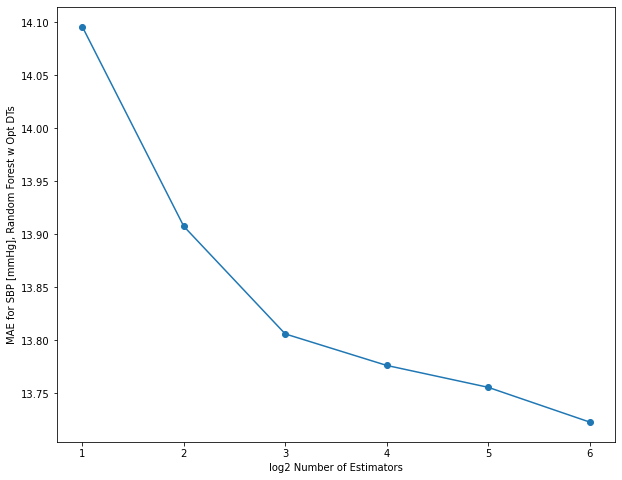

In [72]:
#    3) Random Forest: Better than tree reg, as it is built over multiple averaged TR's
from sklearn.ensemble import RandomForestRegressor

N_estimator_vec = [2, 4, 8, 16, 32, 64]
MAE_FR_vec = [0]*len(N_estimator_vec)

for Nes in range(len(N_estimator_vec)):
    forest_reg = RandomForestRegressor(n_estimators=N_estimator_vec[Nes], max_leaf_nodes=256, min_samples_leaf=50) #msl = 100 .. 50 is better
    forest_reg.fit(train_copy2_tr, train_labels)
    FR_Predictions = forest_reg.predict(test_copy_tr)
    MAE_FR_vec[Nes] = np.mean(abs(test_labels - FR_Predictions))
#print("Random Forest Regression RMSE: ",FR_rmse, " & MAE: ",FR_MAE)
plt.rcParams["figure.figsize"]=10,8
plt.xlabel('log2 Number of Estimators')
plt.ylabel('MAE for SBP [mmHg], Random Forest w Opt DTs')
plt.plot(np.log2(N_estimator_vec), MAE_FR_vec,'-o')
plt.show()

## Ensample learning: 

In [ ]:
# Ensample learning: 

# Voting (diverse over techniqes) SHOULD I TRY IT OVER THE ALGORITHM I AM ALREADY USING? 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='hard'
    )
voting_clf.fit(X_train, y_train)


# Bagging & Pasting (diverse over training data)
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=500,
        max_samples=100, bootstrap=True, n_jobs=-1
    )
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

### 4.0 Regulated Models

#### 4.0.1 Ridge Regression

In [7]:

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(train_copy2_tr, train_labels)
ridge_Predictions = ridge_reg.predict(test_copy_tr)

from sklearn.metrics import mean_squared_error
ridge_mse = mean_squared_error(test_labels, ridge_Predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_MAE = np.mean(abs(test_labels - ridge_Predictions))
print("Ridge Regression has RMSE: ",ridge_rmse, " and MAE: ", ridge_MAE)
print("Training MAE: ", np.mean(abs(train_labels - ridge_reg.predict(train_copy2_tr))), "Test MAE: ", ridge_MAE)

Ridge Regression has RMSE:  5.64887375783416  and MAE:  4.57845094080368
Training MAE:  4.74194391883461 Test MAE:  4.57845094080368


#### 4.0.2 Polynomial Regression

In [9]:
# Regulated polynomial regression -- using Ridge with Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import numpy as np
# prepare polynomial
deg_p = 2
alp = 100 # was 1 .. it looks like it does not matter for the second degree! 
poly_features = PolynomialFeatures(degree=deg_p, include_bias=False)
X_poly = poly_features.fit_transform(train_copy2_tr)
# ridge regression using the polynomial features
poly_ridge_reg = Ridge(alpha=alp, solver="cholesky")
poly_ridge_reg.fit(X_poly, train_labels)
poly_ridge_Predictions = poly_ridge_reg.predict(poly_features.fit_transform(test_copy_tr)) 

from sklearn.metrics import mean_squared_error
poly_ridge_mse = mean_squared_error(test_labels, poly_ridge_Predictions)
poly_ridge_rmse = np.sqrt(poly_ridge_mse)
poly_ridge_MAE = np.mean(abs(test_labels - poly_ridge_Predictions))
print("Polynomial Ridge Regression of degree: ", deg_p, " has RMSE: ",poly_ridge_rmse, " and MAE: ", poly_ridge_MAE)
print("Training MAE: ", np.mean(abs(train_labels - poly_ridge_reg.predict(X_poly))), "Test MAE: ", poly_ridge_MAE)

Polynomial Ridge Regression of degree:  2  has RMSE:  5.5966838347516505  and MAE:  4.5196822520459845
Training MAE:  4.635697540375938 Test MAE:  4.5196822520459845


#### 4.0.3 Regulated Decision Trees

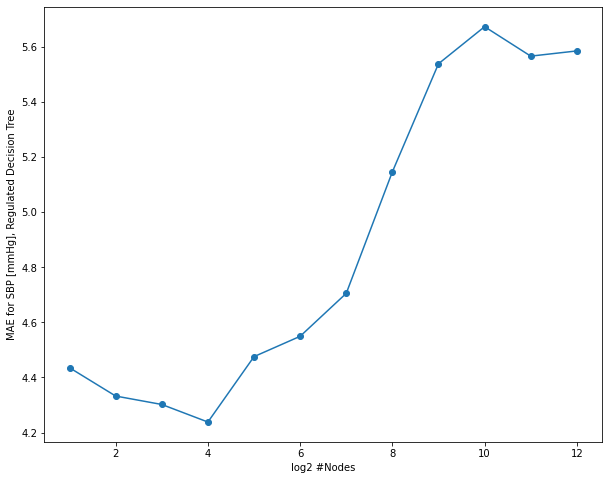

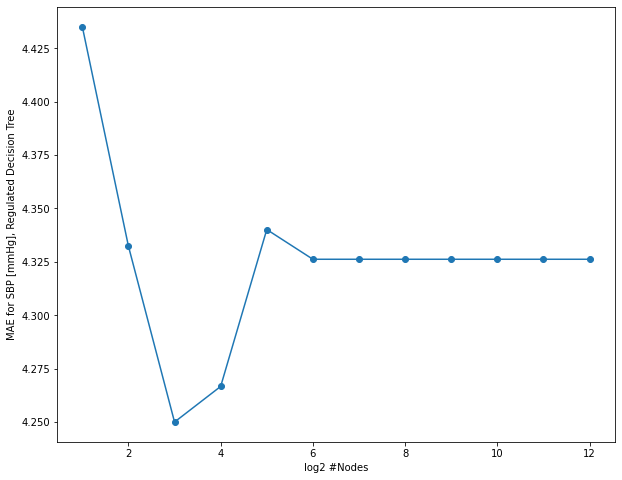

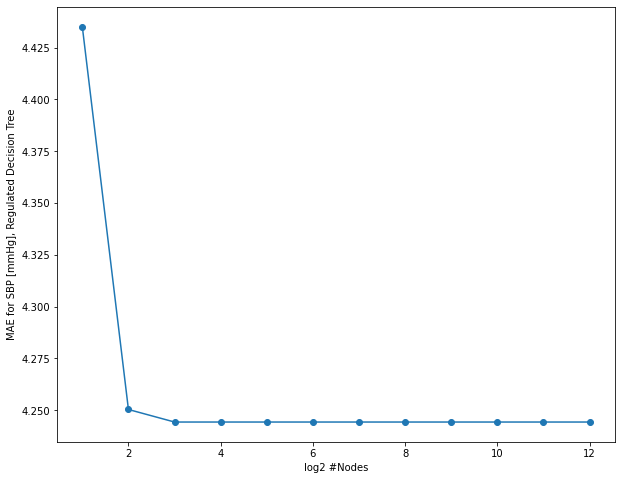

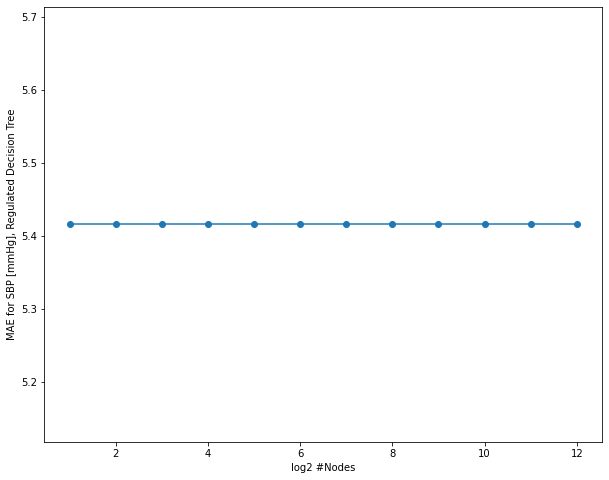

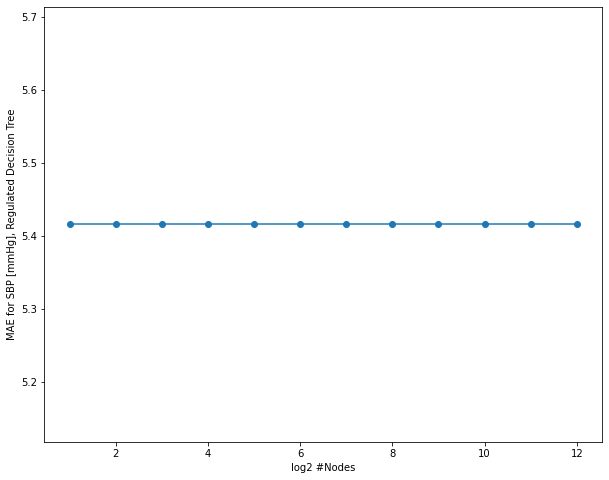

In [10]:
#min_samples_leaf=10

min_samples_vec = [1,10,100,500,1000]

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

Nodes = [2,4,8,16,32,64,128,256,512,1024,2048,4096]

for k in min_samples_vec:
    MAE_TR = [0]*len(Nodes)
    TR_Error = pd.DataFrame()
    
    for i in range(len(Nodes)):
        # Create Model
        file_name = "SBP_DT_"+str(Nodes[i])+"_Nodes"
        tree_reg = DecisionTreeRegressor(max_leaf_nodes=Nodes[i],min_samples_leaf=k) 
        tree_reg.fit(train_copy2_tr, train_labels)
        TR_Predictions = tree_reg.predict(test_copy_tr)
        
        # Calculate Prediction Errors & MAE
        error_TR = abs(test_labels - TR_Predictions)
        TR_Error[str(Nodes[i])] = error_TR
        MAE_TR[i] = np.mean(error_TR)
    
    #print("min samples leaf: ", k, " MAE", MAE_TR)
    # Now plot MAE's
    plt.rcParams["figure.figsize"]=10,8
    plt.xlabel('log2 #Nodes')
    plt.ylabel('MAE for SBP [mmHg], Regulated Decision Tree')
    plt.plot(np.log2(Nodes),MAE_TR,'-o')
    plt.show()


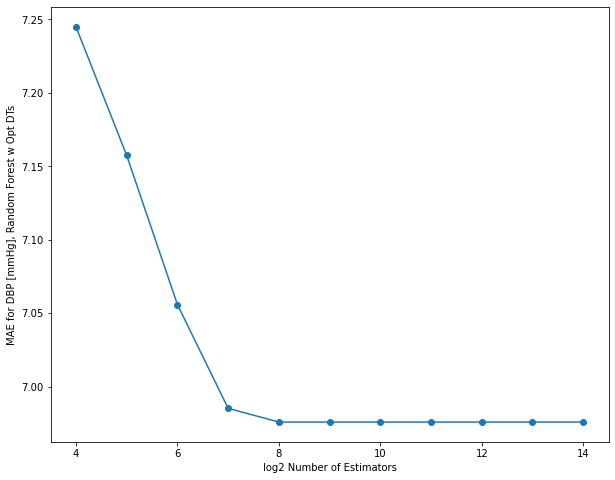

In [57]:
#    3) Random Forest: Better than tree reg, as it is built over multiple averaged TR's
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

max_leaf_vec = [16,32,64,128,256, 512, 1024, 2048, 4096, 2*4096, 4*4096]
MAE_DT_vec_DBP = [0]*len(max_leaf_vec)

for Nl in range(len(max_leaf_vec)):
    DT_reg_DBP = DecisionTreeRegressor(max_leaf_nodes=max_leaf_vec[Nl], min_samples_leaf=200)
    DT_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)    
    Test_Predictions_DBP = DT_reg_DBP.predict(test_copy_tr_DBP)
    #Train_Predictions_DBP = DT_reg_DBP.predict(train_copy2_tr_DBP)
    MAE_DT_vec_DBP[Nl] = np.mean(abs(test_labels_DBP - Test_Predictions_DBP))
#print("Random Forest Regression RMSE: ",FR_rmse, " & MAE: ",FR_MAE)
plt.rcParams["figure.figsize"]=10,8
plt.xlabel('log2 Number of Estimators')
plt.ylabel('MAE for DBP [mmHg], Random Forest w Opt DTs')
plt.plot(np.log2(max_leaf_vec), MAE_DT_vec_DBP,'-o')
plt.show()

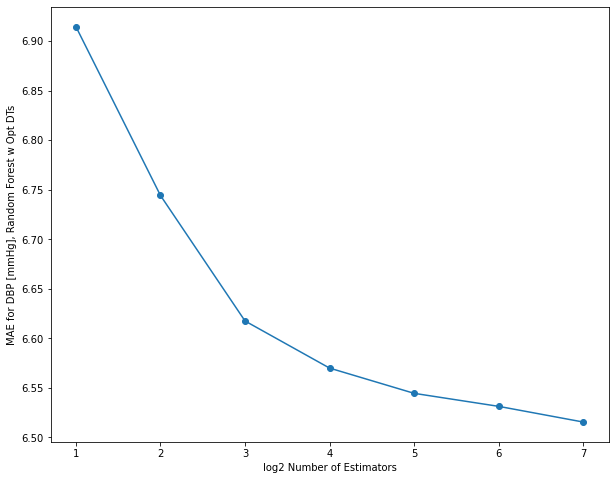

In [26]:
#    3) Random Forest: Better than tree reg, as it is built over multiple averaged TR's
from sklearn.ensemble import RandomForestRegressor
N_estimator_vec = [2, 4, 8, 16, 32, 64, 128]
MAE_FR_vec_DBP = [0]*len(N_estimator_vec)

for Nes in range(len(N_estimator_vec)):
    forest_reg_DBP = RandomForestRegressor(n_estimators=N_estimator_vec[Nes], max_leaf_nodes=4096, min_samples_leaf=1) #msl = 100 .. 50 is better
    forest_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)
    FR_Predictions_DBP = forest_reg_DBP.predict(test_copy_tr_DBP)
    MAE_FR_vec_DBP[Nes] = np.mean(abs(test_labels_DBP - FR_Predictions_DBP))
#print("Random Forest Regression RMSE: ",FR_rmse, " & MAE: ",FR_MAE)
plt.rcParams["figure.figsize"]=10,8
plt.xlabel('log2 Number of Estimators')
plt.ylabel('MAE for DBP [mmHg], Random Forest w Opt DTs')
plt.plot(np.log2(N_estimator_vec), MAE_FR_vec_DBP,'-o')
plt.show()